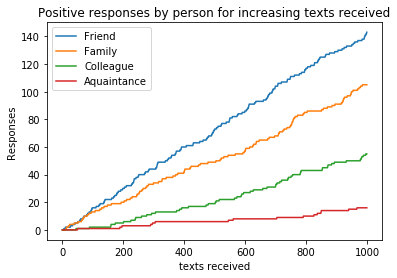

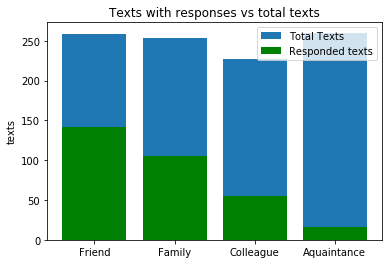

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jul 20 15:34:47 2018

@author: Duncan C-S
"""

# This code will create a fictional list of text messages to be used as a sample
# data set for SmartSilent

import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pylab as plt
import seaborn
import string

# Defining the list of contacts
Names = ['Friend', 'Family', 'Colleague', 'Aquaintance']
MessagesFile = pd.DataFrame( columns = ['Name','Time','Received'])

# Creating 1000 incoming texts

T = pd.Timestamp(2018,1,1)
j = -1
for i in range(1000):
    j = j + 1
    # A text is received from a random person
    N = Names[np.random.randint(0,4)] 
    MessagesFile.loc[j, 'Name'] = N 
    MessagesFile.loc[j, 'Time'] = T 
    MessagesFile.loc[j, 'Received'] = True # Wether the text is incoming or outgoing
    
    # A random response time is chosen on the interval of 0 and 2 hours.
    Delta = pd.Timedelta(hours=np.random.randint(0,2), minutes = np.random.randint(0,60))
    
    j = j + 1
    # For each contact there a probability for a response.
    # In addition, 'Friend' has a 30 minute shorter response time, and aquaintance
    # has a 30 minute longer response time
    if N == 'Friend' and np.random.random_sample() > 0.25:
        Delta = Delta - pd.Timedelta(minutes = 30)
        T = T + Delta 
        MessagesFile.loc[j] = ('Friend', T, False)
        
    elif N == 'Family' and np.random.random_sample() > 0.25:
        T = T + Delta
        MessagesFile.loc[j] = ('Family', T, False)

    elif N == 'Colleague' and np.random.random_sample() > 0.5:
        T = T + Delta
        MessagesFile.loc[j] = ('Colleague', T, False)

    elif N == 'Aquaintance' and np.random.random_sample() > 0.75:
        Delta = Delta + pd.Timedelta(minutes = 30)
        T = T + Delta 
        MessagesFile.loc[j] = ('Aquaintance', T, False)
    else:
        T = T + Delta
        j = j - 1
        
# The messages data set is finished being constructed
        
# The following Code is used for making the plots and the only purpose is to be
# facilitate visualizing the data in MessagesFile

# If a message is responded to in 60 minutes, then the message response status
# is True
Cut_off = pd.Timedelta(minutes = 60)

# This dataFrame is used solely for plotting
NamesPlot = ['Friend','FriendTotal','Family','FamilyTotal','Colleague','ColleagueTotal','Aquaintance','AquaintanceTotal']
Plot = pd.DataFrame(data = np.zeros((1,len(NamesPlot))), columns = NamesPlot)
j = 0

# Searches through each message, if the condition that a response happened is 
# True, then the total responses for that name is updated.
for i in range(1,len(MessagesFile)-1):    
    if MessagesFile.loc[i, 'Received'] == True:
        j = j + 1

        N = MessagesFile.loc[i, 'Name']
        Plot.loc[j] = Plot.loc[j-1]
        time_delay = MessagesFile.loc[i+1, 'Time'] - MessagesFile.loc[i, 'Time']
        if MessagesFile.loc[i+1,'Received'] == False and time_delay < Cut_off:
            response = True
            Plot.loc[j, N] = Plot.loc[j, N] + 1
            Plot.loc[j, N + 'Total'] = Plot.loc[j, N + 'Total'] + 1
            
        else:
            response = False
            Plot.loc[j, N + 'Total'] = Plot.loc[j, N + 'Total'] + 1
            
    else:
        received = False

plt.plot(Plot[Names])
plt.legend(Names)
plt.title("Positive responses by person for increasing texts received")
plt.ylabel("Responses")
plt.xlabel("texts received")
plt.show()

plt.figure()

PlotData = Plot.loc[998]
plt.bar(Names,PlotData[['FriendTotal','FamilyTotal','ColleagueTotal','AquaintanceTotal']], label = 'Total Texts')
plt.bar(Names,PlotData[Names], color = 'g', label = 'Texts with Responses')
plt.legend()
plt.ylabel("texts")
plt.title("Texts with responses vs total texts")
plt.show()


In [5]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jul 20 16:05:47 2018

@author: Duncan C-S
"""

# The following code uses MessagesFile as a training set to determine the
# probabilty that a user will want to have a phone on silent or not on silent.

# This is accomplished twice, the first time stores data on each text that is
# received and sent, Bayes theorm is then used to derive the probability of the
# user wanting to receive the next text from that person.

# Seccond, the same insights are attempted to be drawn however data from each
# text is NOT recorded. Instead a probability value is updated with each iteration

# The rational: A need to develop 'smart' software using ML without needing to
# send private data to a cloud server. Instead instance based learning may be
# employed as a way to have offline ML on any device. without a need for storing
# large amounts of private data.

### Storing data, using Bayes theorum

Contacts = pd.DataFrame(data = {'Names': Names})
# App starts here:

Contacts['Returns'] = np.zeros(len(Contacts.Names))
# Returns is the total value of texts replied to per contact
Contacts['Total'] = np.zeros(len(Contacts.Names))
# Total is the number of texts received per contact
Contacts['Bayes Probability']= np.zeros(len(Contacts.Names))
# Bayes Probability uses the data stored on each contact (ie. Returns and total)
# and uses these values to calculate the probability of wanting to respond to that person.

Contacts['Likelihood'] = np.zeros(len(Contacts.Names))
# Likelihood is the is the percentage of texts responded to by each contact.
Contacts['Evidence'] = np.zeros(len(Contacts.Names))
# Evidence is the confidence in the likelihood value
Contacts['Last'] = np.zeros(len(Contacts.Names))
# Last stores the number of the last text received from that person
Contacts['Modified Bayes Probabiliy'] = np.zeros(len(Contacts.Names))
# "Modified Bayes Probability" is the probability of a text being returned.
# It is calculated using "likelihood" and "Evidence" neither of which collect
# absolute data.

Cut_off = pd.Timedelta(minutes = 60)
TotalSent = 0
Prior = 1

# Collecting Data
def Increase_TotalSent(TotalSent):
    TotalSent = TotalSent+1
    return TotalSent

def Increase_Returns(name):
    Returns = Contacts.loc[Contacts['Names'] == name, 'Returns']
    Returns = Returns + 1
    Contacts.loc[Contacts['Names'] == name, 'Returns'] = Returns

def Increase_TotalReceived(name):
    Total = Contacts.loc[Contacts['Names'] == name, 'Total']
    Total = Total + 1
    Contacts.loc[Contacts['Names'] == name, 'Total'] = Total
    
# Not directly collecting data, just tracking probability
def Increase_Prior(Prior, n):
    Prior = (Prior*n+1)/(n+1)
    return Prior
    
def Increase_Likelihood(name, n, Prior):   
    Last = Contacts.loc[Contacts['Names'] == name, 'Last']
    S = n*Prior
    Likelihood = Contacts.loc[Contacts['Names'] == name, 'Likelihood']
    Likelihood = (Likelihood*Last + 1)/S
    Contacts.loc[Contacts['Names'] == name, 'Likelihood'] = Likelihood

def Increase_Evidence(name, n):
    Evidence = Contacts.loc[Contacts['Names'] == name, 'Evidence']
    Last = Contacts.loc[Contacts['Names'] == name, 'Last']
    Evidence = (Evidence*Last + 1)/(n+1)
    Contacts.loc[Contacts['Names'] == name, 'Evidence'] = Evidence
    
def Update_last(name, count):
    Contacts.loc[Contacts['Names'] == name, 'Last'] = count

# Iterate through all past messages to quantify trends
count = 0
for i in range(0,len(MessagesFile)-1):    
    if MessagesFile.loc[i, 'Received'] == True:
        count = count + 1

        N = MessagesFile.loc[i, 'Name']

        time_delay = MessagesFile.loc[i+1, 'Time'] - MessagesFile.loc[i, 'Time']
        if MessagesFile.loc[i+1,'Received'] == False and time_delay < Cut_off:
            response = True

            TotalSent = Increase_TotalSent(TotalSent)
            Increase_Returns(N)
            Increase_TotalReceived(N)

            Prior = Increase_Prior(Prior, count)
            Increase_Likelihood(N, count, Prior)
            Increase_Evidence(N, count)
            Update_last(N, count)
            
        else:
            response = False
            Update_last(N, count)
            Increase_TotalReceived(N)
            Increase_Evidence(N, count)

    else:
        received = False

# Use information from past texts to predict future probability
for Name in Names:
    Returns = Contacts.loc[Contacts['Names'] == Name, 'Returns']
    Total = Contacts.loc[Contacts['Names'] == Name, 'Total']
    Likelihood = Contacts.loc[Contacts['Names'] == Name, 'Likelihood']
    Evidence = Contacts.loc[Contacts['Names'] == Name, 'Evidence']

    Contacts.loc[Contacts['Names'] == Name, "Bayes Probability"]\
    = (Returns * TotalSent)/ (Total * Total)

    Contacts.loc[Contacts['Names'] == Name, "Modified Bayes Probabiliy"]\
    = (Likelihood * Prior)/ Evidence

print(Contacts)
# The above code attempts to demonstrate a new method of using bayes statistics
# to determine posterior probability, without the need for storing personal 
# information


def Incoming_Text(Name):
    Posterior = Contacts.loc[Contacts['Names'] == Name, 'Modified Bayes Probabiliy']
    if  0.5 < float(Posterior):
        print("Message received from "+ Name +", ringer is on")
    else:
        print('Message received from '+ Name + ', ringer is off')

         Names  Returns  Total  Bayes Probability  Likelihood  Evidence  \
0       Friend    143.0  259.0           0.680029    0.253188  0.316404   
1       Family    105.0  254.0           0.519174    0.223952  0.374371   
2    Colleague     55.0  227.0           0.340488    0.105289  0.486559   
3  Aquaintance     16.0  260.0           0.075503    0.049759  0.733878   

     Last  Modified Bayes Probabiliy  
0  1000.0                   0.800206  
1   991.0                   0.598210  
2   999.0                   0.216396  
3   996.0                   0.067802  
